In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
df = pd.read_csv('data/upsample.csv')

df.head()

,x,y,z,bvp,eda,hr,LABEL
0,15.0,18.0,59.0,9.70,0.566581,98.0,0
1,15.0,18.0,59.0,9.15,0.566581,98.0,0
2,15.0,17.0,59.0,8.00,0.566581,98.0,0
3,15.0,17.0,59.0,6.26,0.566581,98.0,0
4,16.0,18.0,60.0,4.11,0.566581,98.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620978 entries, 0 to 1620977
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   x       1620978 non-null  float64
 1   y       1620978 non-null  float64
 2   z       1620978 non-null  float64
 3   bvp     1620978 non-null  float64
 4   eda     1620978 non-null  float64
 5   hr      1620978 non-null  float64
 6   LABEL   1620978 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 86.6 MB


In [4]:
df.isnull().sum()

x        0
y        0
z        0
bvp      0
eda      0
hr       0
LABEL    0
dtype: int64

In [5]:
df['LABEL'].unique()

array([0, 1, 2], dtype=int64)

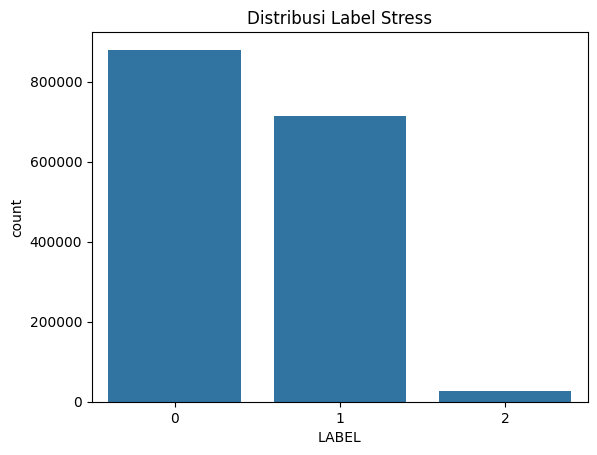

In [6]:
# Visualisasi distribusi label
sns.countplot(x='LABEL', data=df)
plt.title('Distribusi Label Stress')
plt.show()

In [7]:
def remove_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = ~((data < lower_bound) | (data > upper_bound)).any(axis=1)
    return data[mask]

# Pilih kolom numerik untuk deteksi outlier
numeric_cols = ['x','y','z','bvp','eda','hr']
df_clean = remove_outliers_iqr(df[numeric_cols])
df = df.loc[df_clean.index]  # simpan hanya data tanpa outlier

print(f"\nData setelah menghapus outlier: {df.shape[0]} baris")


Data setelah menghapus outlier: 1163255 baris


In [ ]:
print(f"Total data outlier: {1620978 - 1163255}")

# Tampilkan data dengan LABEL = 2
label_2 = df[df['LABEL'] == 2]
print(label_2)

# Jika ingin tahu jumlah datanya:
print("\nJumlah data dengan LABEL = 2:", len(label_2))

Total data outlier: 457723
           x     y     z    bvp       eda     hr  LABEL
641458  22.0  43.0  32.0  32.71  0.006401  55.50      2
641459   8.0  42.0  25.0  -9.74  0.006401  55.50      2
641500 -22.0  24.0  51.0 -49.35  0.008962  64.67      2
641501 -22.0  24.0  51.0 -27.31  0.008962  64.67      2
641502 -28.0  24.0  44.0  -4.68  0.008962  64.67      2
...      ...   ...   ...    ...       ...    ...    ...
768902 -25.0  -5.0  60.0 -26.13  2.677000  99.43      2
768903 -24.0  -5.0  61.0  -6.09  2.677000  99.43      2
768904 -24.0  -5.0  61.0  13.00  2.677000  99.43      2
768905 -26.0  -5.0  60.0  30.52  2.677000  99.43      2
768906 -26.0  -5.0  60.0  46.65  2.677000  99.43      2

[8878 rows x 7 columns]

Jumlah data dengan LABEL = 2: 8878


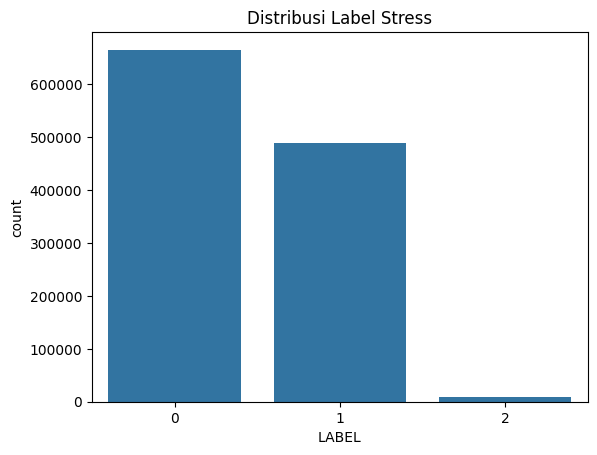

In [9]:
# Visualisasi distribusi label
sns.countplot(x='LABEL', data=df)
plt.title('Distribusi Label Stress')
plt.show()

In [ ]:
# Pisahkan fitur dan target
X = df[['x','y','z','bvp','eda','hr']]
y = df['LABEL']

# Split data dulu (SMOTE hanya untuk train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

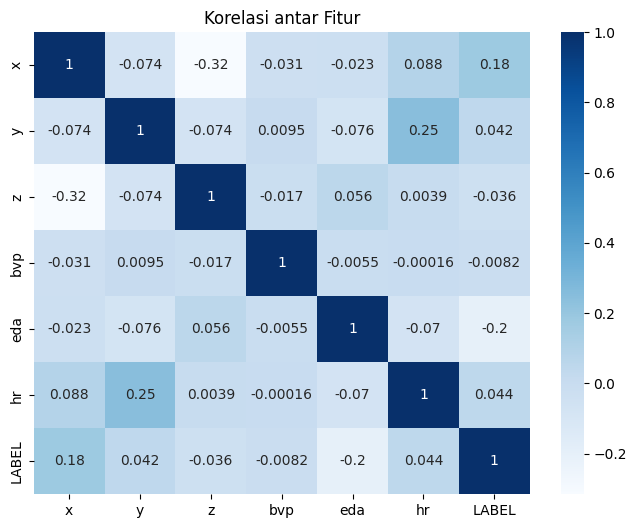

In [11]:
# Korelasi antar fitur
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.title('Korelasi antar Fitur')
plt.show()

In [35]:
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)

print("[Tanpa SMOTE]")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC (multi-class):", roc_auc_score(y_test, y_proba, multi_class='ovr'))

[Tanpa SMOTE]
Accuracy: 0.997880946138207
Confusion Matrix:
 [[132886    207      3]
 [   254  97525      0]
 [    13     16   1747]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    133096
           1       1.00      1.00      1.00     97779
           2       1.00      0.98      0.99      1776

    accuracy                           1.00    232651
   macro avg       1.00      0.99      1.00    232651
weighted avg       1.00      1.00      1.00    232651

ROC-AUC (multi-class): 0.9999701741284798


In [13]:
# =====================================
# 🔁 Cross Validation (macro F1)
# =====================================
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1_macro')
print("F1 Macro (5-Fold CV):", scores.mean())

F1 Macro (5-Fold CV): 0.9928518987370796



Jumlah data sebelum SMOTE: {0: 532383, 1: 391119, 2: 7102}
Jumlah data sesudah SMOTE : {1: 532383, 0: 532383, 2: 532383}


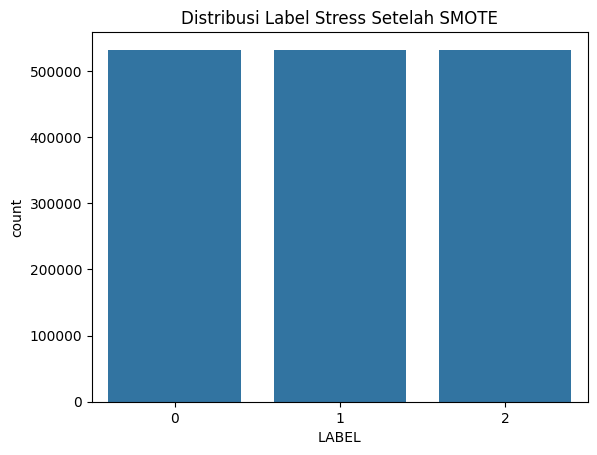

In [33]:
# =====================================
# ⚙️ Terapkan SMOTE hanya pada data training
# =====================================
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

print("\nJumlah data sebelum SMOTE:", y_train.value_counts().to_dict())
print("Jumlah data sesudah SMOTE :", pd.Series(y_res).value_counts().to_dict())

# Visualisasi distribusi label
y_res_df = pd.DataFrame({'LABEL': y_res})
sns.countplot(x='LABEL', data=y_res_df)
plt.title('Distribusi Label Stress Setelah SMOTE')
plt.show()

In [ ]:
# =====================================
# 🌲 Model Random Forest dengan SMOTE
# =====================================
# pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
# pipeline.fit(X_res)

model_smote = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
model_smote.fit(X_res, y_res)

y_pred_smote = model_smote.predict(X_test_scaled)
y_proba_smote = model_smote.predict_proba(X_test_scaled)

print("\n🔹 [Dengan SMOTE]")
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))
print("ROC-AUC (multi-class):", roc_auc_score(y_test, y_proba_smote, multi_class='ovr'))


🔹 [Dengan SMOTE]
Accuracy: 0.9977906821806053
Confusion Matrix:
 [[132832    233     31]
 [   216  97541     22]
 [     6      6   1764]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    133096
           1       1.00      1.00      1.00     97779
           2       0.97      0.99      0.98      1776

    accuracy                           1.00    232651
   macro avg       0.99      1.00      0.99    232651
weighted avg       1.00      1.00      1.00    232651

ROC-AUC (multi-class): 0.9999706647521166


In [16]:
# =====================================
# 🔁 Cross Validation (macro F1) dengan SMOTE
# =====================================
scores_smote = cross_val_score(
    model_smote, X_res, y_res, cv=cv, scoring='f1_macro'
)
print("F1 Macro (5-Fold CV, SMOTE):", scores_smote.mean())

F1 Macro (5-Fold CV, SMOTE): 0.9975866200117667


In [22]:
# Save Model

joblib.dump(model_smote, "model.pkl")
print("💾 Model disimpan sebagai model.pkl")

💾 Model disimpan sebagai model.pkl


In [34]:
import pickle

# Misal model kamu bernama 'rf_model'
with open("model/model-tanpa-smote.pkl", "wb") as f:
    pickle.dump(model, f)


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [18]:
import pickle

with open("model/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [19]:
import pickle
model = pickle.load(open("model/model-smote.pkl", "rb"))
print(model)


RandomForestClassifier(random_state=42)


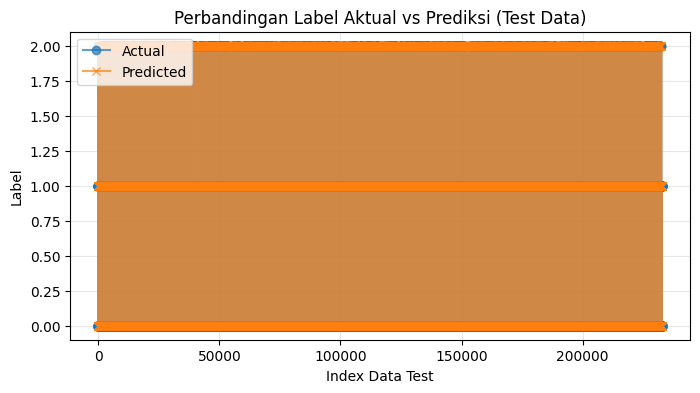

In [24]:
# ==========================
# 🔍 VISUALISASI: ACTUAL vs PREDICT
# ==========================
plt.figure(figsize=(8,4))
plt.plot(range(len(y_test)), y_test.values, label="Actual", marker='o', alpha=0.7)
plt.plot(range(len(y_pred_smote)), y_pred_smote, label="Predicted", marker='x', alpha=0.7)
plt.title("Perbandingan Label Aktual vs Prediksi (Test Data)")
plt.xlabel("Index Data Test")
plt.ylabel("Label")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


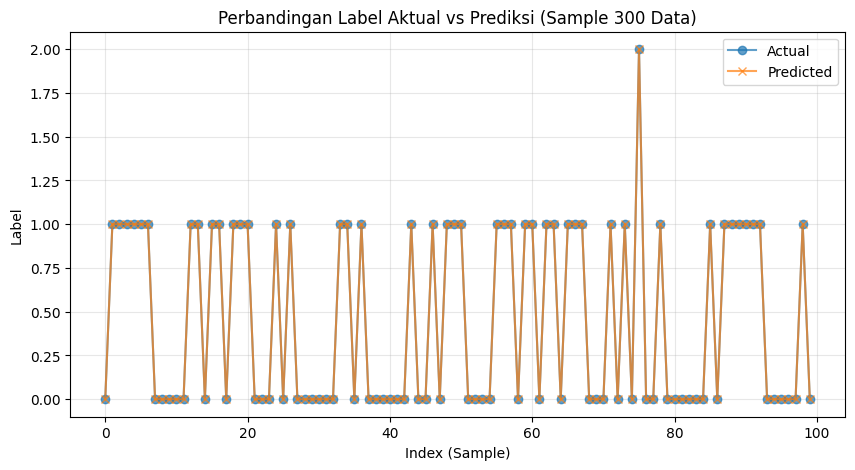

In [41]:
# ==========================
# 🔍 1. SAMPLE SEBAGIAN DATA UNTUK VISUALISASI
# ==========================
# Ambil hanya sebagian kecil (misal 300 data acak)
sample_idx = np.random.choice(range(len(y_test)), size=100, replace=False)
y_test_sample = y_test.iloc[sample_idx]
y_pred_sample = y_pred_smote[sample_idx]

plt.figure(figsize=(10, 5))
plt.plot(y_test_sample.values, 'o-', label="Actual", alpha=0.7)
plt.plot(y_pred_sample, 'x-', label="Predicted", alpha=0.7)
plt.title("Perbandingan Label Aktual vs Prediksi (Sample 300 Data)")
plt.xlabel("Index (Sample)")
plt.ylabel("Label")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

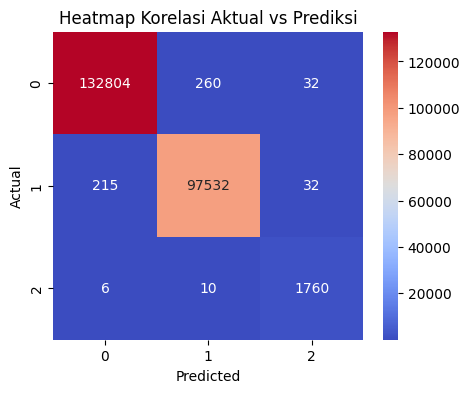

In [25]:
# ==========================
# 🔍 HEATMAP KORELASI AKTUAL VS PREDIKSI
# ==========================
plt.figure(figsize=(5,4))
sns.heatmap(pd.crosstab(y_test, y_pred_smote), annot=True, cmap="coolwarm", fmt='d')
plt.title("Heatmap Korelasi Aktual vs Prediksi")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

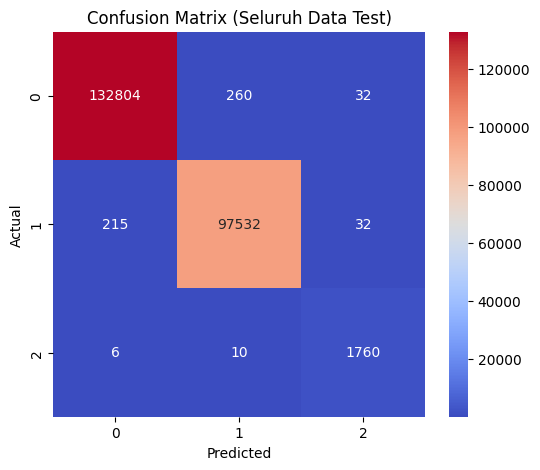

In [27]:
# ==========================
# 🔍 2. CONFUSION MATRIX (lebih akurat)
# ==========================
cm = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix (Seluruh Data Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

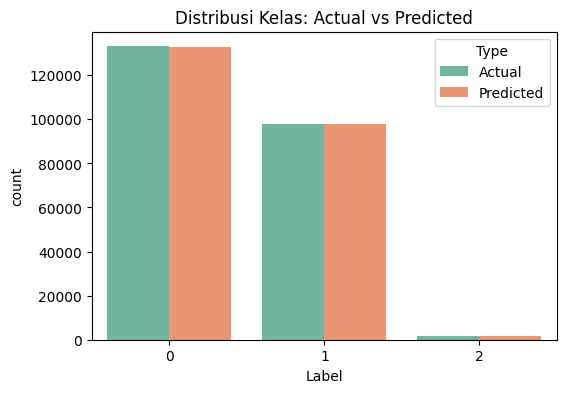

In [28]:
# ==========================
# 🔍 3. VISUALISASI PERBANDINGAN LABEL PER KELAS
# ==========================
df_compare = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_smote
})

plt.figure(figsize=(6,4))
sns.countplot(data=df_compare.melt(var_name='Type', value_name='Label'),
              x='Label', hue='Type', palette='Set2')
plt.title("Distribusi Kelas: Actual vs Predicted")
plt.show()

In [ ]:
# Modeling

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='rbf', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

results = {}

for name, model in models.items():
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n📈 Model: {name}")
    print(f"Akurasi: {acc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


📈 Model: Logistic Regression
Akurasi: 0.4564
Confusion Matrix:
[[54955 38685 39456]
 [21025 49897 26857]
 [  192   258  1326]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.41      0.53    133096
           1       0.56      0.51      0.53     97779
           2       0.02      0.75      0.04      1776

    accuracy                           0.46    232651
   macro avg       0.43      0.56      0.37    232651
weighted avg       0.65      0.46      0.53    232651



c:\Users\risqi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



📈 Model: SVM
Akurasi: 0.5093
Confusion Matrix:
[[101276  24744   7076]
 [ 76865  16729   4185]
 [  1277      6    493]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.76      0.65    133096
           1       0.40      0.17      0.24     97779
           2       0.04      0.28      0.07      1776

    accuracy                           0.51    232651
   macro avg       0.34      0.40      0.32    232651
weighted avg       0.49      0.51      0.47    232651


📈 Model: Random Forest
Akurasi: 0.9978
Confusion Matrix:
[[132832    233     31]
 [   216  97541     22]
 [     6      6   1764]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    133096
           1       1.00      1.00      1.00     97779
           2       0.97      0.99      0.98      1776

    accuracy                           1.00    232651
   macro avg       0.99      1.00      0.99    23

In [52]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_res, y_res)
y_pred = knn.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\n📈 Model: KNN")
print(f"Akurasi: {acc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


📈 Model: KNN
Akurasi: 0.9458
Confusion Matrix:
[[128237   4216    643]
 [  6920  90166    693]
 [    58     84   1634]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    133096
           1       0.95      0.92      0.94     97779
           2       0.55      0.92      0.69      1776

    accuracy                           0.95    232651
   macro avg       0.82      0.94      0.86    232651
weighted avg       0.95      0.95      0.95    232651

